In [35]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import dask.config
import dask
import polars as pl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [5]:
df1 = pd.read_csv("heat_profile_data.csv",index_col=0)
df2 = pd.read_csv("heat_demand_data.csv", index_col=0)
df3 = pd.read_csv("heat_demand_by_building_data.csv",index_col=0)
df4 = pd.read_csv("COP_data.csv", index_col=0)

In [6]:
# Function to handle duplicate column names by appending numbers
def deduplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [f"{dup}_{i}" if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Ensure unique columns for all DataFrames
for df in [df1, df2, df3, df4]:
    df = deduplicate_columns(df)
    df.reset_index(drop=True, inplace=True)

# Function to style DataFrames like SQL tables with center alignment and spacing
def style_table(df, title):
    styled_df = df.head().style.set_table_attributes("style='display: block; margin: 20px auto; width: 80%;'")\
        .set_caption(f"<b style='font-size:16px'>{title}</b>")\
        .set_properties(**{
            'background-color': '#fdfdfd',
            'color': '#333333',
            'border-color': 'black',
            'border-style': 'solid',
            'border-width': '1px',
            'text-align': 'center',
            'padding': '8px'
        })\
        .highlight_max(axis=0, color='#d4edda')\
        .highlight_min(axis=0, color='#f8d7da')
    
    return styled_df

# Display each styled table with spacing between them
display(style_table(df1, '📊 DataFrame 1 heat_profile_data'))
display(style_table(df2, '📊 DataFrame 2 heat_demand_data'))
display(style_table(df3, '📊 DataFrame 3 heat_demand_by_building_data'))
display(style_table(df4, '📊 DataFrame 4 cop_data'))

,cet_cest_timestamp,country,profile_type,water,space
0,2007-12-31T23:00:00+0100,AT,COM,66,211
1,2007-12-31T23:00:00+0100,AT,MFH,68,158
2,2007-12-31T23:00:00+0100,AT,SFH,12,177
3,2008-01-01T00:00:00+0100,AT,COM,66,211
4,2008-01-01T00:00:00+0100,AT,MFH,68,158


,utc_timestamp,cet_cest_timestamp,country,heat_demand_space,heat_demand_water,heat_demand_total
0,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000
1,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000
2,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000
3,2008-01-01T01:00:00Z,2008-01-01T02:00:00+0100,AT,9636.000000,395.000000,10031.000000
4,2008-01-01T02:00:00Z,2008-01-01T03:00:00+0100,AT,10198.000000,438.000000,10636.000000


,cet_cest_timestamp,country,building_type,water,space
0,2007-12-31T23:00:00+0100,AT,COM,167.000000,3959.000000
1,2007-12-31T23:00:00+0100,AT,MFH,124.000000,1479.000000
2,2007-12-31T23:00:00+0100,AT,SFH,53.000000,3882.000000
3,2008-01-01T00:00:00+0100,AT,COM,167.000000,3959.000000
4,2008-01-01T00:00:00+0100,AT,MFH,124.000000,1479.000000


,cet_cest_timestamp,country,source,floor,radiator,water
0,2007-12-31T23:00:00+0100,AT,ASHP,2.800000,2.240000,2.030000
1,2007-12-31T23:00:00+0100,AT,GSHP,3.720000,2.770000,2.400000
2,2007-12-31T23:00:00+0100,AT,WSHP,4.570000,3.320000,2.800000
3,2008-01-01T00:00:00+0100,AT,ASHP,2.800000,2.240000,2.030000
4,2008-01-01T00:00:00+0100,AT,GSHP,3.720000,2.770000,2.400000


In [9]:
# Rename 'profile_type' to 'building_type' in df1 so it matches df3 for merging
df1_renamed = df1.rename(columns={'profile_type': 'building_type'})

# Merge df1 and df3 on matching keys
merged_1_3 = pd.merge(
    df1_renamed,
    df3,
    on=['cet_cest_timestamp', 'country', 'building_type'],
    suffixes=('_profile', '_demand'),
    how='left'  # or 'inner' if you only want matching records
)

# Merge df2 and df4 on matching keys
merged_2_4 = pd.merge(
    df2,
    df4,
    on=['cet_cest_timestamp', 'country'],
    suffixes=('_demand', '_cop'),
    how='left'
)

In [11]:
del df1, df2, df3, df4

In [13]:
# Function to style and display a DataFrame like an SQL table
def style_sql_table(df, title):
    styled_df = df.head(10).style.set_table_attributes("style='display: block; margin: 20px auto; width: 90%; border-collapse: collapse;'")\
        .set_caption(f"<b style='font-size:16px'>{title}</b>")\
        .set_properties(**{
            'background-color': '#fcfcfc',
            'color': '#333333',
            'border': '1px solid #999',
            'text-align': 'center',
            'padding': '6px'
        })\
        .highlight_max(axis=0, color='#d4edda')\
        .highlight_min(axis=0, color='#f8d7da')
    return styled_df

# Display the merged DataFrames like SQL tables
display(style_sql_table(merged_1_3, '📄 Merged Heat Profile & Building Demand (Top 10 Rows)'))
display(style_sql_table(merged_2_4, '📄 Merged Heat Demand & COP (Top 10 Rows)'))

,cet_cest_timestamp,country,building_type,water_profile,space_profile,water_demand,space_demand
0,2007-12-31T23:00:00+0100,AT,COM,66,211,167.000000,3959.000000
1,2007-12-31T23:00:00+0100,AT,MFH,68,158,124.000000,1479.000000
2,2007-12-31T23:00:00+0100,AT,SFH,12,177,53.000000,3882.000000
3,2008-01-01T00:00:00+0100,AT,COM,66,211,167.000000,3959.000000
4,2008-01-01T00:00:00+0100,AT,MFH,68,158,124.000000,1479.000000
5,2008-01-01T00:00:00+0100,AT,SFH,12,177,53.000000,3882.000000
6,2008-01-01T01:00:00+0100,AT,COM,83,215,210.000000,4024.000000
7,2008-01-01T01:00:00+0100,AT,MFH,70,160,129.000000,1503.000000
8,2008-01-01T01:00:00+0100,AT,SFH,15,178,64.000000,3905.000000
9,2008-01-01T02:00:00+0100,AT,COM,86,218,218.000000,4090.000000


,utc_timestamp,cet_cest_timestamp,country,heat_demand_space,heat_demand_water,heat_demand_total,source,floor,radiator,water
0,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,ASHP,2.800000,2.240000,2.030000
1,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,GSHP,3.720000,2.770000,2.400000
2,2007-12-31T22:00:00Z,2007-12-31T23:00:00+0100,AT,9320.000000,344.000000,9664.000000,WSHP,4.570000,3.320000,2.800000
3,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,ASHP,2.800000,2.240000,2.030000
4,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,GSHP,3.720000,2.770000,2.400000
5,2007-12-31T23:00:00Z,2008-01-01T00:00:00+0100,AT,9320.000000,344.000000,9664.000000,WSHP,4.570000,3.320000,2.800000
6,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,ASHP,2.800000,2.230000,2.020000
7,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,GSHP,3.700000,2.750000,2.390000
8,2008-01-01T00:00:00Z,2008-01-01T01:00:00+0100,AT,9432.000000,402.000000,9834.000000,WSHP,4.570000,3.310000,2.800000
9,2008-01-01T01:00:00Z,2008-01-01T02:00:00+0100,AT,9636.000000,395.000000,10031.000000,ASHP,2.780000,2.210000,2.020000


In [23]:
# Function to style and display a DataFrame like an SQL table
def style_sql_table(df, title):
    styled_df = df.head(10).style.set_table_attributes("style='display: block; margin: 20px auto; width: 95%; border-collapse: collapse;'")\
        .set_caption(f"<b style='font-size:16px'>{title}</b>")\
        .set_properties(**{
            'background-color': '#fcfcfc',
            'color': '#333333',
            'border': '1px solid #999',
            'text-align': 'center',
            'padding': '6px'
        })\
        .highlight_max(axis=0, color='#d4edda')\
        .highlight_min(axis=0, color='#f8d7da')
    return styled_df

# Step 0: Compute COP if not already in the DataFrame
# 1. Create a safe copy of merged DataFrames
df1_copy = merged_1_3.copy()
df2_copy = merged_2_4.copy()

# 2. Merge both sides (profiles + demand/COP)
df_full = pd.merge(
    df1_copy,
    df2_copy,
    on=['cet_cest_timestamp', 'country'],
    how='inner'  # inner ensures rows are aligned on both time + country
)

# Check if 'cop' is already in the DataFrame
if 'cop' not in df_full.columns:
    if 'heat_demand_total' in df_full.columns and 'heat_demand_space' in df_full.columns:
        df_full['cop'] = df_full['heat_demand_space'] / df_full['heat_demand_total']
    else:
        raise ValueError("Missing columns to calculate 'cop'.")

# Step 1: Select numeric and grouping columns
group_cols = ['building_type', 'country', 'source']
num_cols = ['heat_demand_space', 'heat_demand_water', 'heat_demand_total', 'cop']

# Step 2: Filter down for safety (and to avoid NaN-only rows)
df_stats = df_full[group_cols + num_cols].dropna(subset=num_cols, how='all')

# Step 3: Group and describe
desc_stats = df_stats.groupby(group_cols)[num_cols].agg(['mean', 'median', 'std', 'min', 'max'])

# Optional: Reset index if you want a DataFrame you can export or work with easily
desc_stats_reset = desc_stats.reset_index()

# Display the styled descriptive statistics table like an SQL table
display(style_sql_table(desc_stats_reset, '📊 Grouped Descriptive Statistics (Top 10 Rows)'))


C:\Users\oppor\AppData\Local\Temp\ipykernel_18708\153891259.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_full['cet_cest_timestamp'] = pd.to_datetime(df_full['cet_cest_timestamp'])
C:\Users\oppor\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


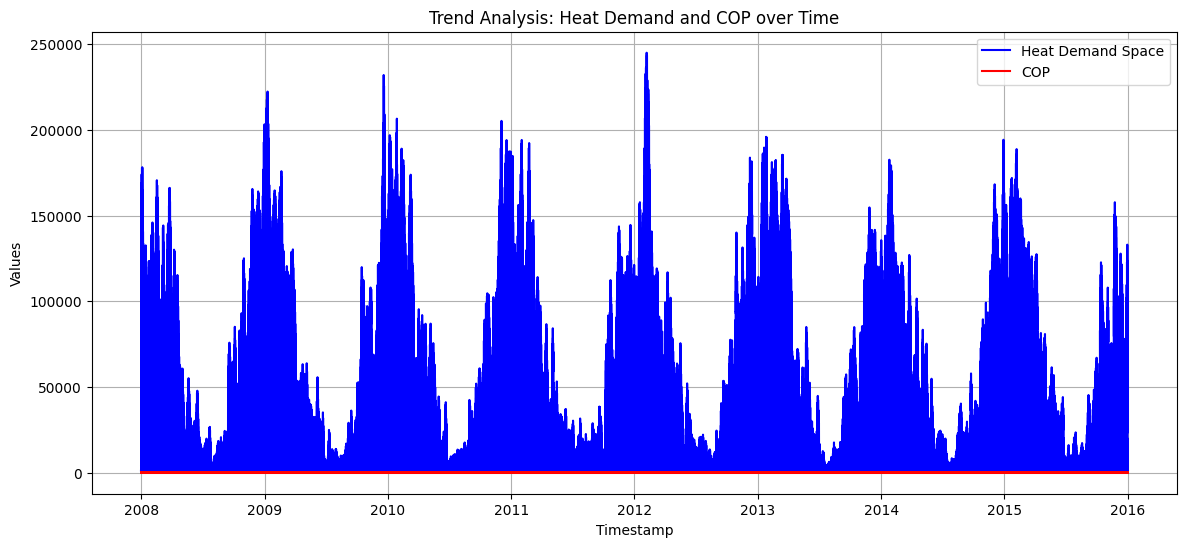

In [27]:
# Convert 'cet_cest_timestamp' to datetime if not already
df_full['cet_cest_timestamp'] = pd.to_datetime(df_full['cet_cest_timestamp'])

# Set the plot size
plt.figure(figsize=(14, 6))

# Plot Heat Demand Space and COP over time
plt.plot(df_full['cet_cest_timestamp'], df_full['heat_demand_space'], label='Heat Demand Space', color='blue')
plt.plot(df_full['cet_cest_timestamp'], df_full['cop'], label='COP', color='red')

plt.title("Trend Analysis: Heat Demand and COP over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

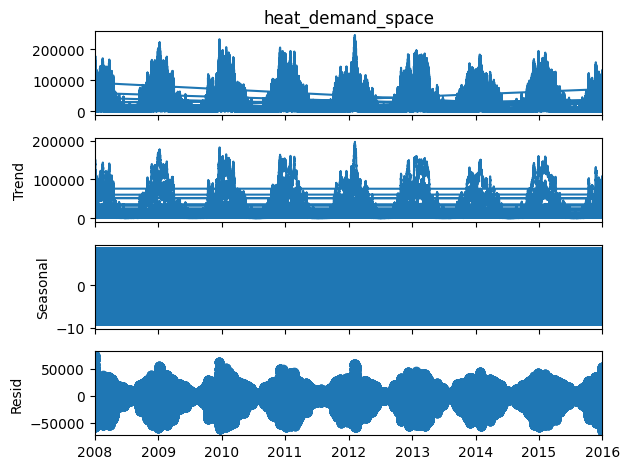

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set 'cet_cest_timestamp' as the index
df_full.set_index('cet_cest_timestamp', inplace=True)

# Decompose the 'heat_demand_space' time series
decomposition = seasonal_decompose(df_full['heat_demand_space'].dropna(), model='additive', period=365)

# Plot the decomposition
decomposition.plot()
plt.show()


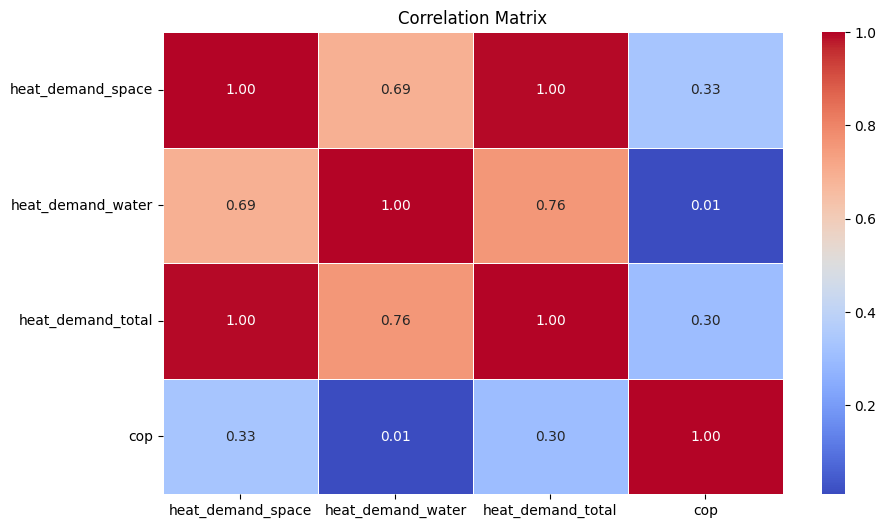

In [39]:
# Compute the correlation matrix
corr_matrix = df_full[num_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [41]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_full['building_type'], df_full['country'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Square: {chi2}, p-value: {p}")


Chi-Square: 0.0, p-value: 1.0
